In [ ]:
## @meermehran -- M3RG Lab -- Indian Institute of Technology, Delhi
## @date : 28Sept2022

####################################--DESCRIPTION####################################################
##                                                                                                 ##
## -----------------------------Benchmarking- FNO-v-ResNet-UNet----------------------------------- ##
##                                                                                                 ##        
#####################################################################################################

In [1]:

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from Adam import Adam
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
import scipy.io as sio

from timeit import default_timer
from utility import *


torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('DEVICE:=', device)

DEVICE:= cuda


#### MODEL

In [2]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride = 1, padding=1)#3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch,kernel_size=3,stride = 1, padding=1)# 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
#             print("before ConvBloc", x.shape)
            x = block(x)
#             print(f'after conv block {x.shape}')
            
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            # print(encoder_features[i].shape, x.shape)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(48,48)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz      = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.out_sz)
        return out

In [8]:
######################################################
### Data Loading
######################################################


X_Data = '/DATA1/meer/data/material-v3-3350.mat'
Y_Data = '/DATA1/meer/data/strain-v3-3350.mat'

ntrain =1200
ntest = 200
batch_size = 20
dim = 48
strain_channels = 3


################################################################
# load data and data normalization
################################################################

reader = MatReader(X_Data)   
x_train = reader.read_field('Emat')[:ntrain]
x_test = reader.read_field('Emat')[-ntest:]
x_test_plot = reader.read_field('Emat')[-ntest:]


reader.load_file(Y_Data) 
y_train = reader.read_field('strain')[:ntrain]#    
y_test_strain = reader.read_field('strain')[-ntest:] 


######################################################
### Normalization
######################################################

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)



train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_strain), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [9]:
print(f' x_train Shape := {x_train.shape}')
print(f' y_train Shape := {y_train.shape}')
print(f' x_test Shape := {x_test.shape}')
print(f' y_test_strain Shape := {y_test_strain.shape}')

 x_train Shape := torch.Size([1200, 48, 48])
 y_train Shape := torch.Size([1200, 48, 48, 3])
 x_test Shape := torch.Size([200, 48, 48])
 y_test_strain Shape := torch.Size([200, 48, 48, 3])


In [10]:
# ################################################################
## Model
# ################################################################

model = UNet().to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-5
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay= 1e-8, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)  ### gamma =0.1
epochs = 500

print(f'Epochs:= {epochs}--- LR:={learning_rate}---BatchSize:= {batch_size}')

MODEL PARAMETERS. :== 31030723
Epochs:= 500--- LR:=1e-05---BatchSize:= 20


In [11]:

# ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim,dim,strain_channels)
   

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 0  ||  TIME(sec):== 1.4218 || TrainError:== 0.710358  ||  TestError:== 0.709678
 Epoch :== 1  ||  TIME(sec):== 1.4467 || TrainError:== 0.710142  ||  TestError:== 0.709732
 Epoch :== 2  ||  TIME(sec):== 1.4643 || TrainError:== 0.710017  ||  TestError:== 0.709638
 Epoch :== 3  ||  TIME(sec):== 1.4742 || TrainError:== 0.710015  ||  TestError:== 0.7096
 Epoch :== 4  ||  TIME(sec):== 1.4629 || TrainError:== 0.709919  ||  TestError:== 0.709567
 Epoch :== 5  ||  TIME(sec):== 1.4745 || TrainError:== 0.709775  ||  TestError:== 0.70792
 Epoch :== 6  ||  TIME(sec):== 1.4576 || TrainError:== 0.706147  ||  TestError:== 0.703627
 Epoch :== 7  ||  TIME(sec):== 1.4813 || TrainError:== 0.701564  ||  TestError:== 0.697456
 Epoch :== 8  ||  TIME(sec):== 1.465 || TrainError:== 0.696075  ||  TestError:== 0.692739
 Epoch :== 9  ||  TIME(sec):== 1.4604 || TrainError:== 0.69177  ||  TestError:== 0.688926
 Epoch :== 10  ||  TIME(sec):== 1.4794 || TrainError:== 0.688464  ||  TestError:== 0.68587
 Epo

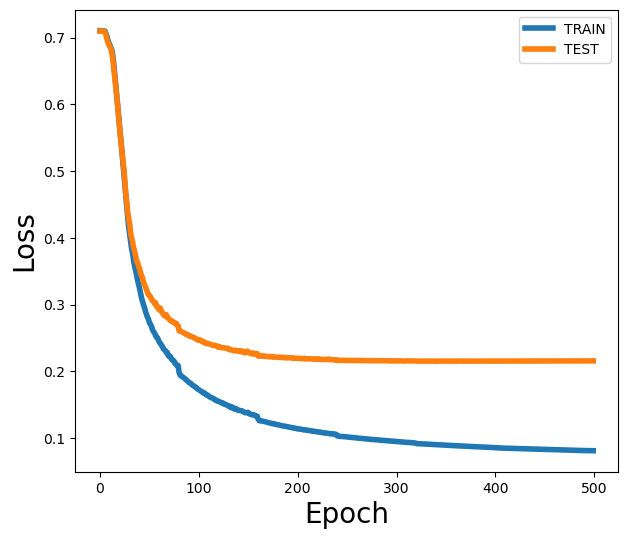

In [12]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror,linewidth = 4,label ="TRAIN")
plt.plot(range(epochs),testerror, linewidth = 4,label ="TEST")
plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.legend()
plt.show()

In [14]:
# trainn = np.array(trainerror)
# testnn = np.array(testerror)
# torch.save(model.state_dict(),'UNet_STRAIN_N1200_ep1200.pt')
# np.save('trainUNET_STRAIN', trainn)
# np.save('testUNET_STRAIN', testnn)

#### Testing-Strains

In [13]:
prediction = torch.zeros(y_test_strain.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [14]:
strain_act = y_test_strain.reshape(ntest, -1)
strain_pred = prediction.reshape(ntest,-1)


In [15]:
r2_strain =[]
for i in range(strain_act.shape[0]):
    act = strain_act[i]
    pred = strain_pred[i]
    r2 = r2_score(act,pred)
    # print(r2)
    # break
    r2_strain += [r2]

In [16]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9443775309476833 0.03338474697973763


In [17]:
##R2 mean and std

print(np.round((r2_avg_strain),2))
print(np.round((r2_std_strain),2))

0.94
0.03


In [18]:
## total test error
loss = lossfunc(y_test_strain, prediction)
print(loss/ntest)

tensor(0.2157)


### STRESS

In [19]:
######################################################
### Data Loading & Hyperparameters
######################################################


X_Data = '/DATA1/meer/data/material-v3-3350.mat'
Y_Data = '/DATA1/meer/data/stress-v3-3350.mat'


ntrain =1200
ntest = 200
batch_size =20


################################################################
# load data and data normalization
################################################################

reader = MatReader(X_Data)   
x_train = reader.read_field('Emat')[:ntrain]
x_test = reader.read_field('Emat')[-ntest:]
x_test_plot = reader.read_field('Emat')[-ntest:]

reader.load_file(Y_Data) 
y_train = reader.read_field('stress')[:ntrain]#   
y_test_stress = reader.read_field('stress')[-ntest:]   

######################################################
### Normalization
######################################################

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_stress), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [20]:
print(f' x_train Shape := {x_train.shape}')
print(f' y_train Shape := {y_train.shape}')
print(f' x_test Shape := {x_test.shape}')
print(f' y_test_stress Shape := {y_test_stress.shape}')

 x_train Shape := torch.Size([1200, 48, 48])
 y_train Shape := torch.Size([1200, 48, 48, 3])
 x_test Shape := torch.Size([200, 48, 48])
 y_test_stress Shape := torch.Size([200, 48, 48, 3])


In [21]:
# ################################################################
## Model
# ################################################################

model = UNet().to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-5
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay= 1e-8, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)  ### gamma =0.1
epochs = 500

print(f'Epochs:= {epochs}--- LR:={learning_rate}---BatchSize:= {batch_size}')

MODEL PARAMETERS. :== 31030723
Epochs:= 500--- LR:=1e-05---BatchSize:= 20


In [22]:

trainerror=[] 
testerror=[]
dim =48
strain_channels = 3
##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)
   

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 0  ||  TIME(sec):== 1.4424 || TrainError:== 0.531698  ||  TestError:== 0.533993
 Epoch :== 1  ||  TIME(sec):== 1.4629 || TrainError:== 0.531504  ||  TestError:== 0.533824
 Epoch :== 2  ||  TIME(sec):== 1.4549 || TrainError:== 0.531432  ||  TestError:== 0.533798
 Epoch :== 3  ||  TIME(sec):== 1.4498 || TrainError:== 0.531344  ||  TestError:== 0.533759
 Epoch :== 4  ||  TIME(sec):== 1.4634 || TrainError:== 0.531135  ||  TestError:== 0.533337
 Epoch :== 5  ||  TIME(sec):== 1.444 || TrainError:== 0.530578  ||  TestError:== 0.53135
 Epoch :== 6  ||  TIME(sec):== 1.4771 || TrainError:== 0.529693  ||  TestError:== 0.529972
 Epoch :== 7  ||  TIME(sec):== 1.454 || TrainError:== 0.525608  ||  TestError:== 0.524158
 Epoch :== 8  ||  TIME(sec):== 1.4641 || TrainError:== 0.520263  ||  TestError:== 0.519836
 Epoch :== 9  ||  TIME(sec):== 1.4598 || TrainError:== 0.516465  ||  TestError:== 0.516924
 Epoch :== 10  ||  TIME(sec):== 1.4715 || TrainError:== 0.5127  ||  TestError:== 0.510038
 Ep

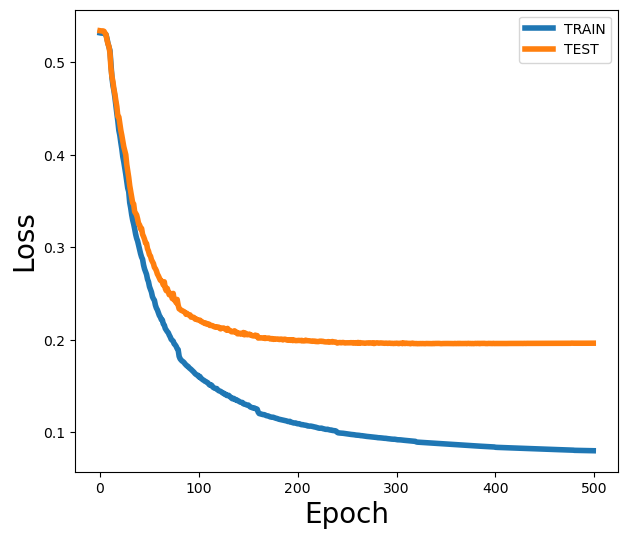

In [23]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror,linewidth = 4,label ="TRAIN")
plt.plot(range(epochs),testerror, linewidth = 4,label ="TEST")
plt.xlabel('Epoch', fontsize =20)
plt.ylabel('Loss', fontsize =20)
plt.legend()
plt.show()

In [24]:
# trainn = np.array(trainerror)
# testnn = np.array(testerror)
# torch.save(model.state_dict(),'UNet_STRESS_N1200_ep1200.pt')
# np.save('trainUNET_STRESS', trainn)
# np.save('testUNET_STRESS', testnn)

In [25]:
prediction = torch.zeros(y_test_stress.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [26]:
stress_act = y_test_stress.reshape(ntest, -1)
stress_pred = prediction.reshape(ntest,-1)

r2_stress =[]
for i in range(stress_act.shape[0]):
    act = stress_act[i]
    pred = stress_pred[i]
    r2 = r2_score(act,pred)
    r2_stress += [r2]

In [27]:
r2_avg_stress = np.average(r2_stress)
r2_std_stress = np.std(r2_stress)

print(r2_avg_stress,r2_std_stress)

0.9320553105736218 0.07767333359342457


In [28]:
print(np.round((r2_avg_stress),2))
print(np.round((r2_std_stress),2))

0.93
0.08


In [29]:
loss = lossfunc(y_test_stress, prediction)
print(loss/ntest)

tensor(0.1964)
